In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import re

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import set_style


## import model objects
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [3]:
df= pd.read_csv("../../Data and data related codes/dataset_reg.csv")

In [4]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df

,Date,CADUSD=X_Open,CADUSD=X_Close,CADUSD=X_High,CADUSD=X_Low,CADUSD=X_Volume,CADUSD=X_Change,CADUSD=X_Gain,CADUSD=X_Loss,CADUSD=X_Avg_Gain,...,F_change_in_price,F_RSI,F_k_percent,F_r_percent,F_MACD,F_MACD_EMA,F_ROC,F_PVT,F_Bollinger_Upper,F_Bollinger_Lower
0,2019-12-30 00:00:00+00:00,0.764859,0.764912,0.766107,0.764316,0,0.002019,0.002019,0.000000,0.001024,...,-0.110000,42.097312,47.541004,-52.458996,0.047284,0.055724,1.536777,1.358339e+06,9.666881,8.805119
1,2019-12-31 00:00:00+00:00,0.765814,0.765662,0.772016,0.765650,0,0.000750,0.000750,0.000000,0.001026,...,0.050000,47.653890,47.058846,-52.941154,0.039446,0.052438,-0.214587,1.533162e+06,9.668690,8.832310
2,2020-01-02 00:00:00+00:00,0.770707,0.770832,0.771087,0.768817,0,0.005170,0.005170,0.000000,0.001370,...,0.120000,58.644046,67.391390,-32.608610,0.040957,0.050125,2.058511,2.093493e+06,9.665091,8.888909
3,2020-01-03 00:00:00+00:00,0.770196,0.770238,0.771533,0.768988,0,-0.000594,0.000000,0.000594,0.001131,...,-0.210000,41.184310,14.285812,-85.714188,0.027377,0.045548,-1.916936,1.089399e+06,9.648241,8.931759
4,2020-01-06 00:00:00+00:00,0.769989,0.770024,0.771426,0.769906,0,-0.000214,0.000000,0.000214,0.001049,...,-0.050000,38.070431,19.607759,-80.392241,0.013069,0.039022,-2.449419,8.539349e+05,9.624073,8.978926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1234,2024-11-22 00:00:00+00:00,0.715308,0.715308,0.716379,0.713435,0,-0.000614,0.000000,0.000614,0.001093,...,0.380000,58.535056,81.481498,-18.518502,0.054790,0.051555,-0.089359,6.166929e+07,11.576416,10.155584
1235,2024-11-25 00:00:00+00:00,0.717731,0.717731,0.718030,0.713949,0,0.002423,0.002423,0.000000,0.001199,...,0.219999,64.721577,86.813106,-13.186894,0.084617,0.058168,4.014595,6.291823e+07,11.582508,10.152492
1236,2024-11-26 00:00:00+00:00,0.709300,0.709300,0.711521,0.705398,0,-0.008430,0.000000,0.008430,0.000948,...,-0.299999,52.416595,53.846186,-46.153814,0.083091,0.063152,1.185051,6.166932e+07,11.590143,10.213857
1237,2024-11-27 00:00:00+00:00,0.711587,0.711587,0.713776,0.710404,0,0.002286,0.002286,0.000000,0.001111,...,0.000000,52.416595,53.846186,-46.153814,0.080948,0.066711,-1.157606,6.166932e+07,11.595563,10.271437


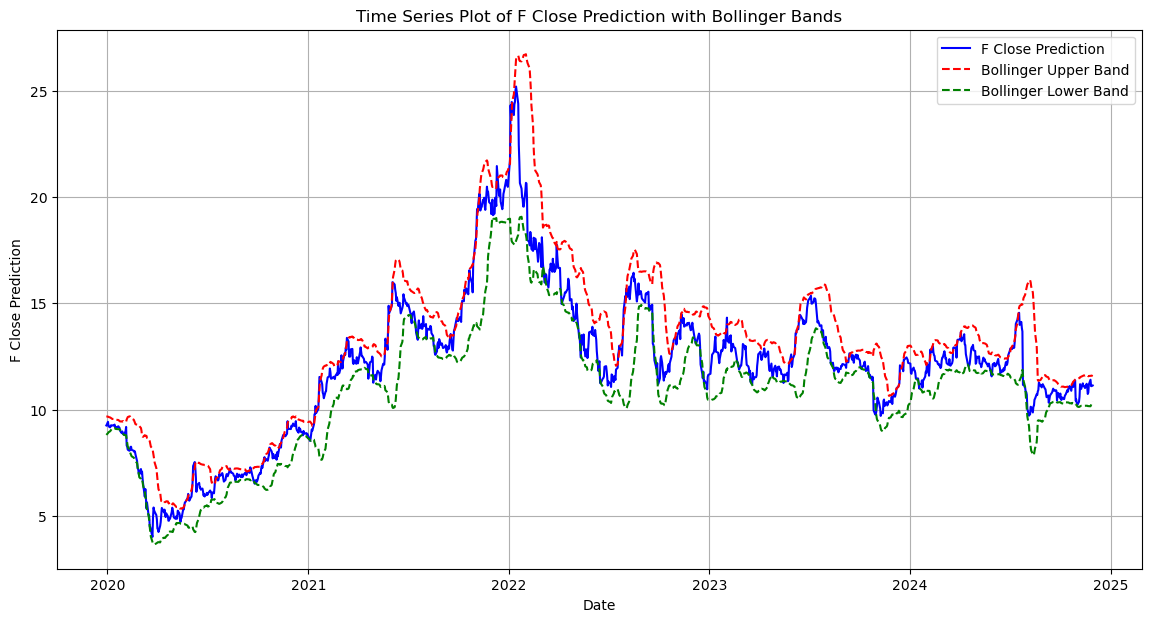

In [5]:
# Plot the time series for F_Close_pred with Bollinger Bands
plt.figure(figsize=(14, 7))

# Plot the predicted close prices
plt.plot(df['Date'], df['F_Close_pred'], label='F Close Prediction', color='blue')

# Plot Bollinger Bands
plt.plot(df['Date'], df['F_Bollinger_Upper'], label='Bollinger Upper Band', color='red', linestyle='--')
plt.plot(df['Date'], df['F_Bollinger_Lower'], label='Bollinger Lower Band', color='green', linestyle='--')

# Add titles and labels
plt.title('Time Series Plot of F Close Prediction with Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('F Close Prediction')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [6]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import pandas as pd
import numpy as np

# Filter for the last 2 months of data
end_date = df['Date'].max()
start_date = end_date - pd.DateOffset(months=2)
df_last_2_months = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Step 1: Prepare features (X) and target (y)
X = df_last_2_months.drop(columns=['Date', 'F_Close_pred', 'F_Bollinger_Upper', 'F_Bollinger_Lower'])
y = df_last_2_months['F_Close_pred']

# Step 2: Split data - keep the last 1 week as an unseen test set
split_index = len(X) - 7
X_train_val, X_unseen_test = X[:split_index], X[split_index:]
y_train_val, y_unseen_test = y[:split_index], y[split_index:]


In [7]:
# Step 3: Standardize and remove skewness using only training data
scaler = StandardScaler()
power_transformer = PowerTransformer()

# Fit scalers only on the training data
X_train_scaled = scaler.fit_transform(X_train_val)
X_train_transformed = power_transformer.fit_transform(X_train_scaled)

# Apply the trained scalers to unseen test data
X_unseen_test_scaled = scaler.transform(X_unseen_test)
X_unseen_test_transformed = power_transformer.transform(X_unseen_test_scaled)

# Step 4: Set up parameter grid for XGBoost hyperparameter tuning
xgb_params = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.01, 0.005],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 5, 10]
}

# Initialize the XGBoost Regressor
xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42)

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# GridSearchCV with TimeSeriesSplit
xgb_cv = GridSearchCV(xgb_reg, xgb_params, scoring='neg_mean_squared_error', cv=tscv)

# Fit the model on the training and validation set
xgb_cv.fit(X_train_transformed, y_train_val)

# Step 5: Collect MSE and best parameters for XGBoost in a table
results = pd.DataFrame({
    'Model': ['XGBoost'],
    'Best Parameters': [xgb_cv.best_params_],
    'Best MSE': [-xgb_cv.best_score_]  # Convert negative MSE back to positive
})

# Display the results table
print("Grid Search Results with MSE for XGBoost Regression:")
print(results)

# Step 6: Choose the best XGBoost model based on the lowest MSE
best_xgb_model = xgb_cv.best_estimator_
print(f"Best XGBoost model: {best_xgb_model}, MSE: {-xgb_cv.best_score_}")

# Step 7: Predict on the unseen test data
y_unseen_pred = best_xgb_model.predict(X_unseen_test_transformed)

# Step 8: Evaluate performance on the unseen test set
mse_unseen = mean_squared_error(y_unseen_test, y_unseen_pred)
print(f"Unseen Test MSE: {mse_unseen}")

Grid Search Results with MSE for XGBoost Regression:
     Model                                    Best Parameters  Best MSE
0  XGBoost  {'colsample_bytree': 0.6, 'gamma': 0, 'learnin...  0.099291
Best XGBoost model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...), MSE: 0.09929109170658802
Unseen Test MSE: 0.0820

In [8]:
results = []

# Retrieve the best model from cross-validation
best_xgb_model = xgb_cv.best_estimator_
best_mse = -xgb_cv.best_score_

# Fit the best model to the entire training and validation set
best_xgb_model.fit(X_train_transformed, y_train_val)

# Predictions on the training data
y_pred_train = best_xgb_model.predict(X_train_transformed)
residuals = y_train_val - y_pred_train

# Calculate the sample size and sum of squared errors
n = len(y_train_val)  # Sample size
sse = np.sum(residuals**2)

# Approximate number of parameters for XGBoost
# A better approximation would account for tree splits and pruning,
# but as an approximation, we consider the number of leaves.
num_trees = best_xgb_model.get_params()['n_estimators']
max_depth = best_xgb_model.get_params()['max_depth']
p = num_trees * (2 ** max_depth - 1)  # Total possible leaves (approximation)

# Safeguard for overestimation
p = min(p, n)  # Ensure p is not greater than n

# Calculate AIC, BIC, and AICc
aic = n * np.log(sse / n) + 2 * p
bic = n * np.log(sse / n) + p * np.log(n)
aicc = aic + (2 * p * (p + 1)) / max(1, (n - p - 1))  # Avoid division by zero

# Store results in a dictionary
results.append({
    'Model': 'XGBoost',
    'Best Parameters': xgb_cv.best_params_,
    'Best MSE': best_mse,
    'AIC': aic,
    'BIC': bic,
    'AICc': aicc
})

# Convert results list to DataFrame for display
results_df = pd.DataFrame(results)

# Display the table
print("Grid Search Results with MSE, AIC, BIC, and AICc for XGBoost:")
print(results_df)


Grid Search Results with MSE, AIC, BIC, and AICc for XGBoost:
     Model                                    Best Parameters  Best MSE  \
0  XGBoost  {'colsample_bytree': 0.6, 'gamma': 0, 'learnin...  0.099291   

          AIC         BIC         AICc  
0 -172.962804 -113.358841  2639.037196  


In [17]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# Step 4: Collect MSE and best parameters for XGBoost in a table
results = pd.DataFrame({
    'Model': ['XGBoost'],
    'Best Parameters': [xgb_cv.best_params_],
    'Best MSE': [-xgb_cv.best_score_]  # Convert negative MSE back to positive
})

# Display the table
print("Grid Search Results with MSE for XGBoost Regression:")
print(results)

# Step 5: Choose the best XGBoost model based on the lowest MSE
best_xgb_model = xgb_cv.best_estimator_
print(f"Best XGBoost model: {best_xgb_model}, MSE: {-xgb_cv.best_score_}")

# Optional: Apply early stopping manually to the best model after tuning
# NOTE: Early stopping requires `eval_set` and appropriate parameters
best_xgb_model.fit(
    X_train_val, 
    y_train_val,
    eval_set=[(X_unseen_test, y_unseen_test)],  # Validation set for early stopping
    # Stops training after 10 rounds with no improvement
    verbose=False                              # Suppress verbose output
)

# Step 6: Predict on the unseen test set
y_unseen_pred = best_xgb_model.predict(X_unseen_test)
mse_unseen = mean_squared_error(y_unseen_test, y_unseen_pred)
print(f"Unseen Test MSE: {mse_unseen}")

# Optional: Save predictions and comparison
comparison_df = pd.DataFrame({
    'Actual': y_unseen_test.values,
    'Predicted': y_unseen_pred
})
print("\nUnseen Test Predictions vs Actual:")
print(comparison_df)

Grid Search Results with MSE for XGBoost Regression:
     Model                                    Best Parameters  Best MSE
0  XGBoost  {'colsample_bytree': 0.6, 'gamma': 0, 'learnin...  0.099291
Best XGBoost model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...), MSE: 0.09929109170658802
Unseen Test MSE: 0.0820

Unseen Test MSE (XGBoost): 0.3189162301474164


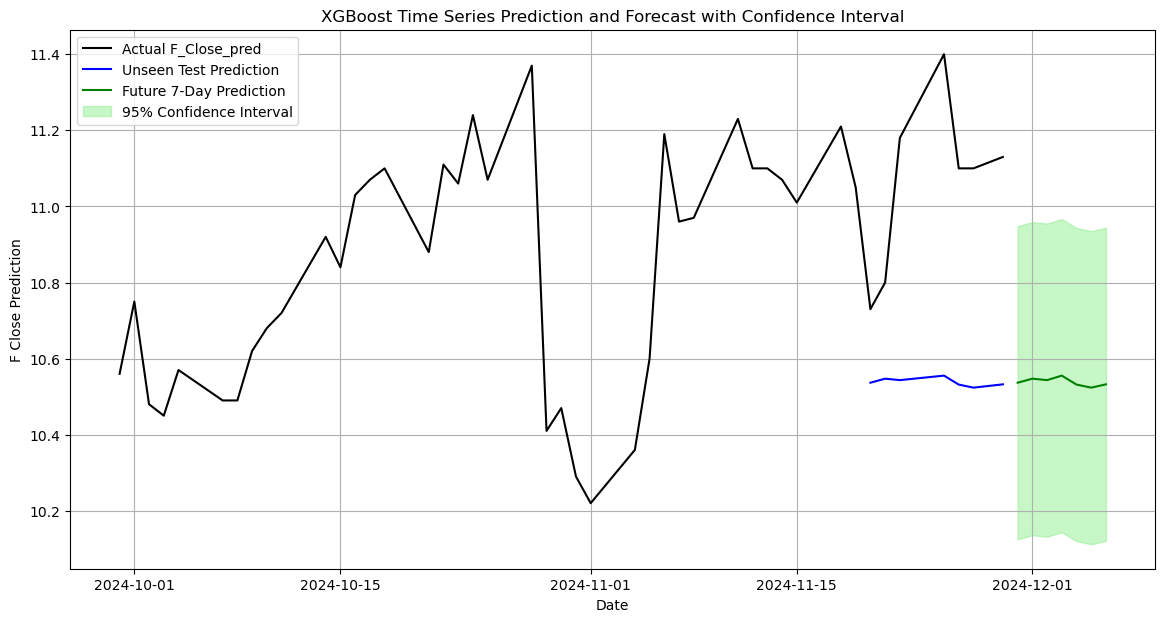

In [18]:
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Step 6: Predict on the last week (unseen test data)
# Ensure unseen test data is scaled and transformed only with previously fitted transformers
X_unseen_test_scaled = scaler.transform(X_unseen_test)
X_unseen_test_transformed = power_transformer.transform(X_unseen_test_scaled)

y_unseen_pred = best_xgb_model.predict(X_unseen_test_transformed)
mse_unseen = mean_squared_error(y_unseen_test, y_unseen_pred)
print(f"Unseen Test MSE (XGBoost): {mse_unseen}")

# Step 7: Forecast the next 7 days with a confidence interval
# Ensure future data is scaled and transformed correctly
future_7_days_raw = X[-7:]  # Extract the raw features for the last 7 days
future_7_days_scaled = scaler.transform(future_7_days_raw)  # Scale using the same scaler
future_7_days_transformed = power_transformer.transform(future_7_days_scaled)  # Transform with same transformer

future_predictions = best_xgb_model.predict(future_7_days_transformed)

# Calculate confidence interval (simple approximation based on prediction standard deviation)
std_dev = np.std(y_unseen_pred - y_unseen_test)  # Standard deviation of residuals
upper_bound = future_predictions + (1.96 * std_dev)
lower_bound = future_predictions - (1.96 * std_dev)

# Plot the results
plt.figure(figsize=(14, 7))

# Plot actual observed values
plt.plot(df_last_2_months['Date'], y, label="Actual F_Close_pred", color='black')

# Plot unseen test predictions for the last week
plt.plot(df_last_2_months['Date'].iloc[-7:], y_unseen_pred, label="Unseen Test Prediction", color='blue')

# Plot future forecast for the next 7 days
future_dates = pd.date_range(df_last_2_months['Date'].iloc[-1] + pd.Timedelta(days=1), periods=7)
plt.plot(future_dates, future_predictions, label="Future 7-Day Prediction", color='green')

# Plot confidence interval
plt.fill_between(future_dates, lower_bound, upper_bound, color='lightgreen', alpha=0.5, label="95% Confidence Interval")

# Labels and title
plt.xlabel("Date")
plt.ylabel("F Close Prediction")
plt.title("XGBoost Time Series Prediction and Forecast with Confidence Interval")
plt.legend()
plt.grid(True)
plt.show()


In [19]:
import numpy as np
import pandas as pd

# Assuming y_unseen_pred and future_predictions have been calculated in prior steps

# Step 1: Ensure test predictions and actuals are properly aligned
# Extract dates for the last two weeks
dates_last_two_weeks = df_last_2_months['Date'].iloc[-14:]

# Extract actual values for the last two weeks
actual_values_last_two_weeks = y.iloc[-14:]

# Ensure the predicted values are NaN for the first week (since unseen data predictions are for the second week only)
# This avoids any leakage or mismatched alignment
predicted_values_last_two_weeks = [np.nan] * 7 + list(y_unseen_pred)

# Step 2: Create a comparison DataFrame for the last two weeks
comparison_df = pd.DataFrame({
    'Date': dates_last_two_weeks.values,
    'Actual F_Close_pred': actual_values_last_two_weeks.values,
    'Predicted F_Close_pred': predicted_values_last_two_weeks
})

# Reset index for a cleaner display
comparison_df.reset_index(drop=True, inplace=True)

# Step 3: Prepare forecast data for the next 7 days
# Generate future dates starting from the last date in the comparison DataFrame
future_dates = pd.date_range(comparison_df['Date'].iloc[-1] + pd.Timedelta(days=1), periods=7)

# Create a DataFrame for the forecasted data
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Actual F_Close_pred': [np.nan] * 7,  # No actual data for the future
    'Predicted F_Close_pred': future_predictions  # Forecasted predictions from XGBoost
})

# Step 4: Append the forecasted data to the comparison DataFrame
comparison_df_with_forecast = pd.concat([comparison_df, forecast_df], ignore_index=True)

# Display the updated table with both last week's predictions and the future forecast
print(comparison_df_with_forecast)


         Date  Actual F_Close_pred  Predicted F_Close_pred
0  2024-11-11                11.23                     NaN
1  2024-11-12                11.10                     NaN
2  2024-11-13                11.10                     NaN
3  2024-11-14                11.07                     NaN
4  2024-11-15                11.01                     NaN
5  2024-11-18                11.21                     NaN
6  2024-11-19                11.05                     NaN
7  2024-11-20                10.73               10.536656
8  2024-11-21                10.80               10.547230
9  2024-11-22                11.18               10.543438
10 2024-11-25                11.40               10.555260
11 2024-11-26                11.10               10.531697
12 2024-11-27                11.10               10.523647
13 2024-11-29                11.13               10.532346
14 2024-11-30                  NaN               10.536656
15 2024-12-01                  NaN               10.5472

## Backtesting

Rolling Backtesting Results for XGBoost (5 Iterations):
                Train Start                 Train End  \
0 2019-12-30 00:00:00+00:00 2020-03-25 00:00:00+00:00   
1 2020-10-14 00:00:00+00:00 2021-01-08 00:00:00+00:00   
2 2021-08-02 00:00:00+00:00 2021-10-25 00:00:00+00:00   
3 2022-05-17 00:00:00+00:00 2022-08-11 00:00:00+00:00   
4 2023-03-06 00:00:00+00:00 2023-05-30 00:00:00+00:00   

                 Test Start                  Test End  \
0 2020-03-26 00:00:00+00:00 2020-04-03 00:00:00+00:00   
1 2021-01-11 00:00:00+00:00 2021-01-20 00:00:00+00:00   
2 2021-10-26 00:00:00+00:00 2021-11-03 00:00:00+00:00   
3 2022-08-12 00:00:00+00:00 2022-08-22 00:00:00+00:00   
4 2023-05-31 00:00:00+00:00 2023-06-08 00:00:00+00:00   

                                     Best Parameters       MSE      RMSE  \
0  {'colsample_bytree': 0.8, 'learning_rate': 0.0...  0.307087  0.554154   
1  {'colsample_bytree': 1.0, 'learning_rate': 0.0...  0.521562  0.722192   
2  {'colsample_bytree': 1.0, '

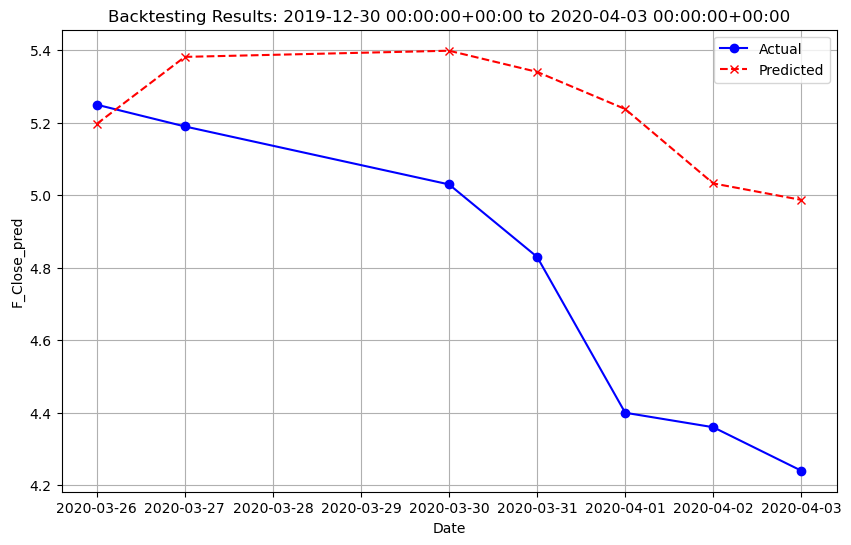

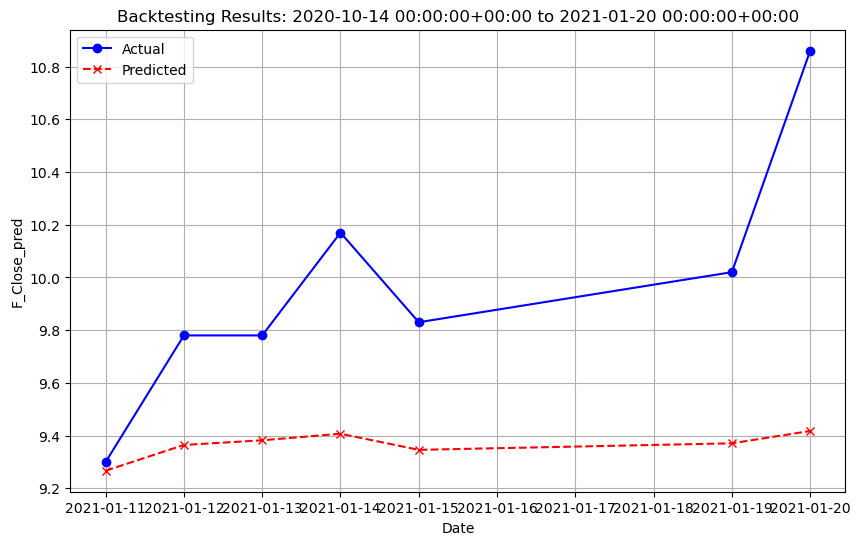

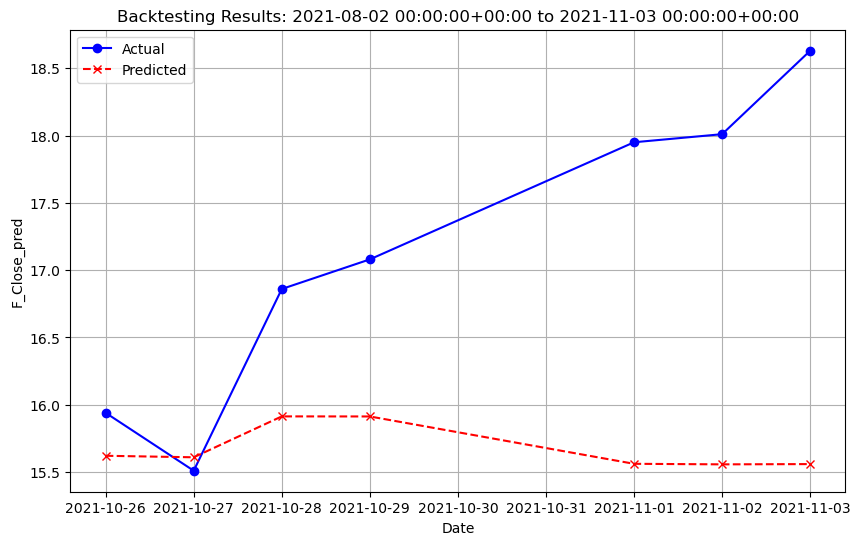

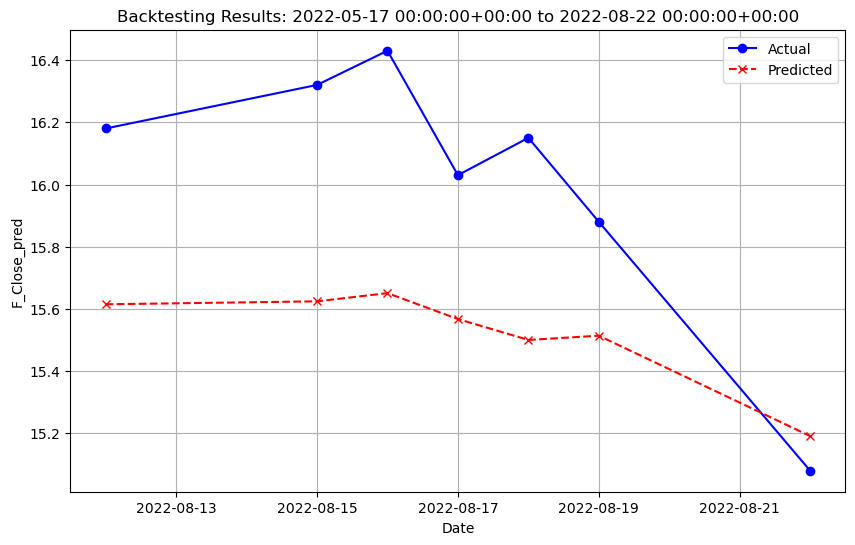

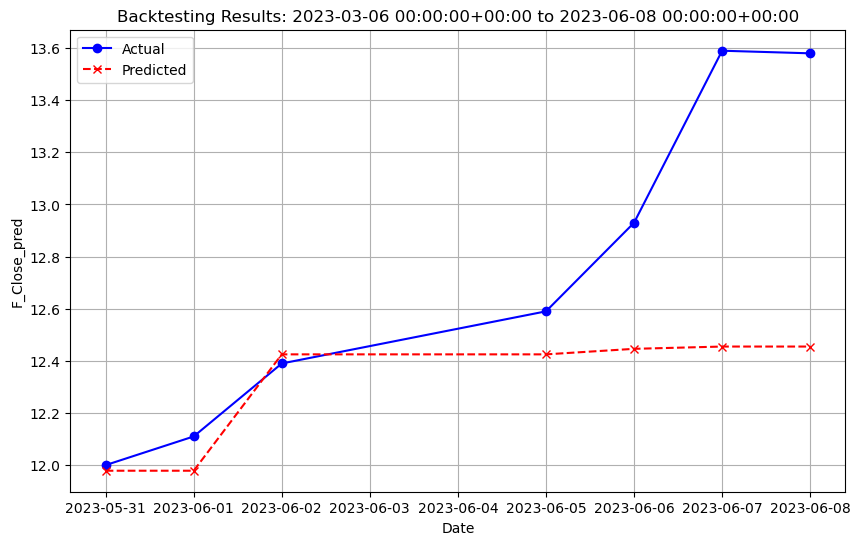

In [20]:
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PowerTransformer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def plot_backtesting_results(backtest_results, df):
    """
    Plot fitted model predictions vs real data for each backtest.
    """
    for idx, row in backtest_results.iterrows():
        # Extract the test period
        test_start = row['Test Start']
        test_end = row['Test End']

        # Filter the actual data for the test period
        test_data = df[(df['Date'] >= test_start) & (df['Date'] <= test_end)]
        y_test = test_data['F_Close_pred'].values

        # Extract predictions for the test period
        y_pred = row['Predictions']

        # Plot the results
        plt.figure(figsize=(10, 6))
        plt.plot(test_data['Date'], y_test, label='Actual', marker='o', linestyle='-', color='blue')
        plt.plot(test_data['Date'], y_pred, label='Predicted', marker='x', linestyle='--', color='red')
        plt.title(f"Backtesting Results: {row['Train Start']} to {row['Test End']}")
        plt.xlabel('Date')
        plt.ylabel('F_Close_pred')
        plt.legend()
        plt.grid(True)
        plt.show()


def rolling_backtesting_xgboost(df, num_backtests=5, window_size_months=2, test_days=7):
    """
    Perform rolling backtesting for XGBoost with grid search for the best parameters.
    """
    backtest_results = []
    start_idx = 0
    total_data_points = len(df)
    backtest_count = 0  # To count the number of backtests performed

    while (
        start_idx + window_size_months * 30 + test_days <= total_data_points 
        and backtest_count < num_backtests
    ):
        # Calculate start and end indices for training and testing
        train_start_idx = start_idx
        train_end_idx = train_start_idx + window_size_months * 30
        test_start_idx = train_end_idx
        test_end_idx = test_start_idx + test_days

        # Prepare the training and testing datasets
        train_data = df.iloc[train_start_idx:train_end_idx]
        test_data = df.iloc[test_start_idx:test_end_idx]

        # Features and target for training
        X_train = train_data.drop(columns=['Date', 'F_Close_pred', 'F_Bollinger_Upper', 'F_Bollinger_Lower'])
        y_train = train_data['F_Close_pred']

        # Features and target for testing
        X_test = test_data.drop(columns=['Date', 'F_Close_pred', 'F_Bollinger_Upper', 'F_Bollinger_Lower'])
        y_test = test_data['F_Close_pred']

        # Preprocess the data
        scaler = StandardScaler()
        power_transformer = PowerTransformer()

        # Fit on training data only to prevent leakage
        X_train_scaled = scaler.fit_transform(X_train)
        X_train_transformed = power_transformer.fit_transform(X_train_scaled)

        # Transform test data using the scaler and transformer fitted on training data
        X_test_scaled = scaler.transform(X_test)
        X_test_transformed = power_transformer.transform(X_test_scaled)

        # Step 4: Set up parameter grids for hyperparameter tuning
        xgb_params = {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.05],
            'max_depth': [3, 5],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        }

        # Initialize the XGBoost Regressor
        xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42)

        # TimeSeriesSplit for cross-validation
        tscv = TimeSeriesSplit(n_splits=5)

        # GridSearchCV with TimeSeriesSplit
        xgb_cv = GridSearchCV(xgb_reg, xgb_params, scoring='neg_mean_squared_error', cv=tscv)

        # Fit the model on training data
        xgb_cv.fit(X_train_transformed, y_train)

        # Find the best model
        best_xgb_model = xgb_cv.best_estimator_

        # Train the best model on the training data
        best_xgb_model.fit(X_train_transformed, y_train)

        # Predict the next 7 days
        y_pred = best_xgb_model.predict(X_test_transformed)

        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        # Append results to backtest_results
        backtest_results.append({
            'Train Start': train_data['Date'].iloc[0],
            'Train End': train_data['Date'].iloc[-1],
            'Test Start': test_data['Date'].iloc[0],
            'Test End': test_data['Date'].iloc[-1],
            'Best Parameters': xgb_cv.best_params_,
            'MSE': mse,
            'RMSE': rmse,
            'R²': r2,
            'Predictions': y_pred
        })

        # Increment the counter and move the window forward by the test period
        backtest_count += 1
        start_idx += 200

    return pd.DataFrame(backtest_results)


# Perform XGBoost rolling backtesting
backtest_results_xgboost = rolling_backtesting_xgboost(df, num_backtests=5)

# Display results
print("Rolling Backtesting Results for XGBoost (5 Iterations):")
print(backtest_results_xgboost)

# Plot the results
plot_backtesting_results(backtest_results_xgboost, df)